In [1]:
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

# Pip Install

In [2]:
!pip install boto3 astropy sfdmap progressbar2 GPUtil

# Initialization

In [3]:
# Make sure a GPU is available
import GPUtil
print('GPUs:\n{0}'.format('\n'.join(['('+str(i+1)+')\t'+gpu.name for i,gpu in enumerate(GPUtil.getGPUs())])))
import tensorflow as tf
assert tf.config.list_physical_devices('GPU')[0].device_type == 'GPU', 'GPU is not available!'

GPUs:
(1)	NVIDIA GeForce GTX 1080 Ti


2023-01-14 16:16:15.507400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 16:16:15.742010: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-14 16:16:16.591817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-14 16:16:16.591904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: 

In [23]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3
from matplotlib import pyplot as plt
import time

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'thesis2')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'thesis2')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_models_dir_path = os.path.join(s3_work_dir_path , 'models')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig
from s3 import log_s3, s3_save_TF_model
from NN import DistanceLayer, SiameseModel, DistillationDataGenerator

# Prepare Data

In [5]:
model_name = 'NN'

In [6]:
# prepare model paths
s3_model_dir_path = os.path.join(s3_models_dir_path, model_name)
s3_model_train_dir_path = os.path.join(s3_model_dir_path, 'train')
s3_model_test_dir_path = os.path.join(s3_model_dir_path, 'test')
# prepare data paths
s3_data_model_dir_path = os.path.join(s3_data_dir_path, model_name)
s3_data_train_dir_path = os.path.join(s3_data_model_dir_path, 'train')
s3_data_test_dir_path = os.path.join(s3_data_model_dir_path, 'test')

In [7]:
# load data
dist_mat_path = os.path.join(s3_models_dir_path, 'SmallRF', 'train', 'dist_mat.npy')
dist_mat = from_s3_npy(s3_client, bucket_name, dist_mat_path)
X_train = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_train_dir_path, 'spec.npy'))
X_test = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_test_dir_path, 'spec.npy'))

loading from uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/dist_mat.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/train/spec.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/test/spec.npy


In [8]:
# gs_SmallRF_train = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_dir_path, 'SmallRF', 'train', 'gs.pkl')) # <- This is equal to g_NN
gs = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_model_dir_path, 'gs.pkl'))
gs_train = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_train_dir_path, 'gs.pkl'))
gs_test = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_test_dir_path, 'gs.pkl'))

loading from uri: s3://tau-astro/almogh/thesis2/data/NN/gs.pkl
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/train/gs.pkl
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/test/gs.pkl


In [9]:
I_train = np.array([np.where(gs.index == i)[0][0] for i in gs_train.index])
I_test = np.array([np.where(gs.index == i)[0][0] for i in gs_test.index])

In [10]:
dist_mat_train = dist_mat[I_train,:][:,I_train]
dist_mat_test = dist_mat[I_test,:][:,I_test]

In [11]:
if is_interactive():
    X_train = X_train[:100,:]
    X_test = X_test[:10,:]
    dist_mat_train = dist_mat_train[:100,:][:,:100]
    dist_mat_test = dist_mat_test[:10,:][:,:10]

# Creating the model

In [12]:
N_features = X_train.shape[1]

In [14]:
from tensorflow.keras import applications
from tensorflow.keras import activations
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras import utils
from tensorflow.keras import initializers

tf.random.set_seed(seed)

## Embedding Network

In [15]:
hidden_size = 512
encoding_size = 128

# input layer
x_in = layers.Input(shape=(N_features, 1))

# adding the network layers
x = x_in
x = layers.Conv1D(64, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(32, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(16, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(8, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(4, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(hidden_size, kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.Dense(encoding_size, kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.tanh(x)
x_out = x

# creating the model
encoding = Model(x_in, x_out)
encoding.summary()

2023-01-14 16:16:26.773486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 16:16:27.659350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10407 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:60:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8400, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 8400, 64)          2048      
                                                                 
 batch_normalization (BatchN  (None, 8400, 64)         256       
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 8400, 64)          0         
                                                                 
 average_pooling1d (AverageP  (None, 4200, 64)         0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4200, 32)          63520 

## Siamese Network

In [16]:
first_input = layers.Input(name="first_input", shape=(N_features))
second_input = layers.Input(name="second_input", shape=(N_features))

first_encoding = encoding(first_input)
second_encoding = encoding(second_input)

distance = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(first_encoding - second_encoding), -1),1e-9))

siamese_network = Model(
    inputs=[first_input, second_input], outputs=distance
)
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 first_input (InputLayer)       [(None, 8400)]       0           []                               
                                                                                                  
 second_input (InputLayer)      [(None, 8400)]       0           []                               
                                                                                                  
 model (Functional)             (None, 128)          694284      ['first_input[0][0]',            
                                                                  'second_input[0][0]']           
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 128)          0           ['model[0][0]',            

## Siamese Model

In [17]:
siamese_model = SiameseModel(siamese_network, dist_loss='L1')
siamese_model.compile(optimizer=optimizers.Adam(0.001))

# Train Model

In [18]:
train_gen = DistillationDataGenerator(X_train, dist_mat_train, batch_size=128, shuffle=True, seed=seed, snr_range_db=[6,40], full_epoch=False, norm=True)
test_gen = DistillationDataGenerator(X_test, dist_mat_test, batch_size=128, shuffle=True, seed=seed, snr_range_db=[6,40], full_epoch=False, norm=True)

In [25]:
def plot_loss(fig, ax, e, loss_history, val_loss_history):
    if ax.lines:
        for i,line in enumerate(ax.lines):
            line.set_xdata(e)
            if (i==1):
                line.set_ydata(loss_history)
            else:
                line.set_ydata(val_loss_history)
    else:
        ax.plot(e, loss_history, label='training')
        ax.plot(e, val_loss_history, label='test')
        ax.legend()
    fig.canvas.draw()

Training for 50 full epochs, and stopping for saving every 5 full epochs, for a total of 10 stages.
-------------------------------------
epochs 1-5:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 632ms/step - loss: 0.0233 - val_loss: 0.0642
Epoch 2/5
1/1 [==============================] - 1s 532ms/step - loss: 0.0277 - val_loss: 0.0599
Epoch 3/5
1/1 [==============================] - 1s 506ms/step - loss: 0.0241 - val_loss: 0.0625
Epoch 4/5
1/1 [==============================] - 1s 539ms/step - loss: 0.0222 - val_loss: 0.0752
Epoch 5/5
1/1 [==============================] - 1s 533ms/step - loss: 0.0263 - val_loss: 0.0983


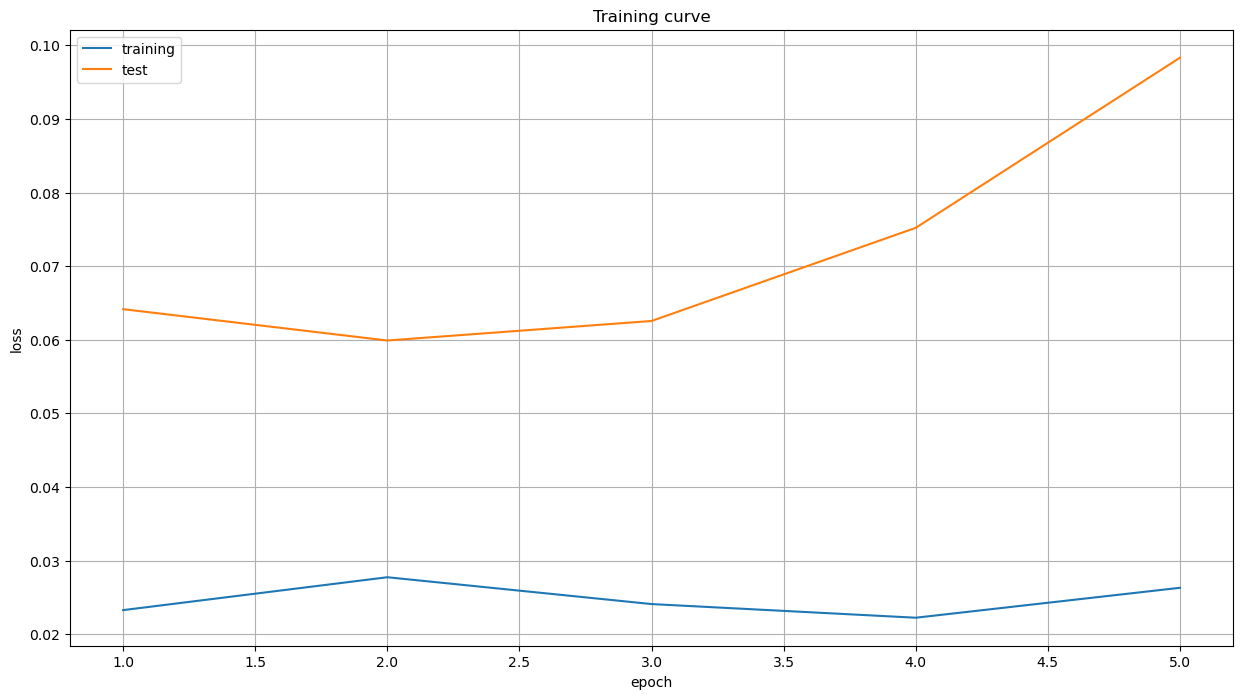

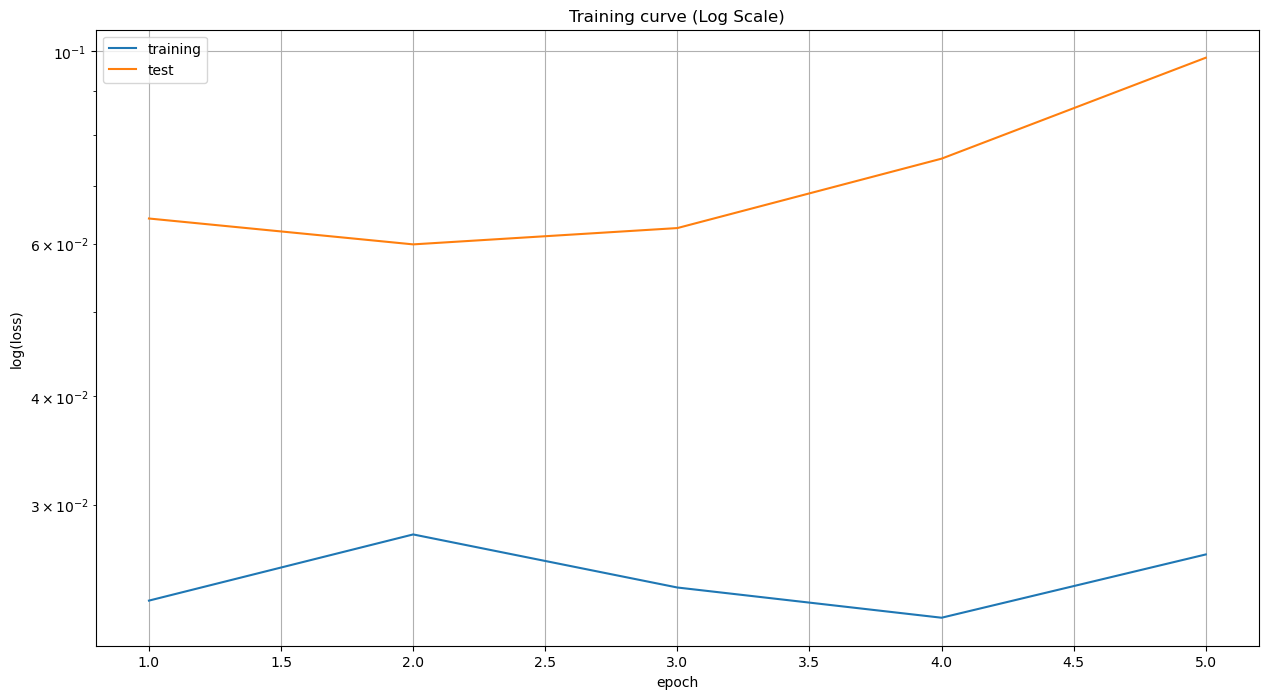

TOTAL TIME = 0.001 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmp0ayjwkwb/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp0ayjwkwb/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/model
-------------------------------------
epochs 6-10:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 677ms/step - loss: 0.0202 - val_loss: 0.0873
Epoch 2/5
1/1 [==============================] - 1s 516ms/step - loss: 0.0220 - val_loss: 0.0710
Epoch 3/5
1/1 [==============================] - 1s 549ms/step - loss: 0.0279 - val_loss: 0.0713
Epoch 4/5
1/1 [==============================] - 1s 541ms/step - loss: 0.0207 - val_loss: 0.0757
Epoch 5/5
1/1 [==============================] - 1s 543ms/step - loss: 0.0233 - val_loss: 0.0634


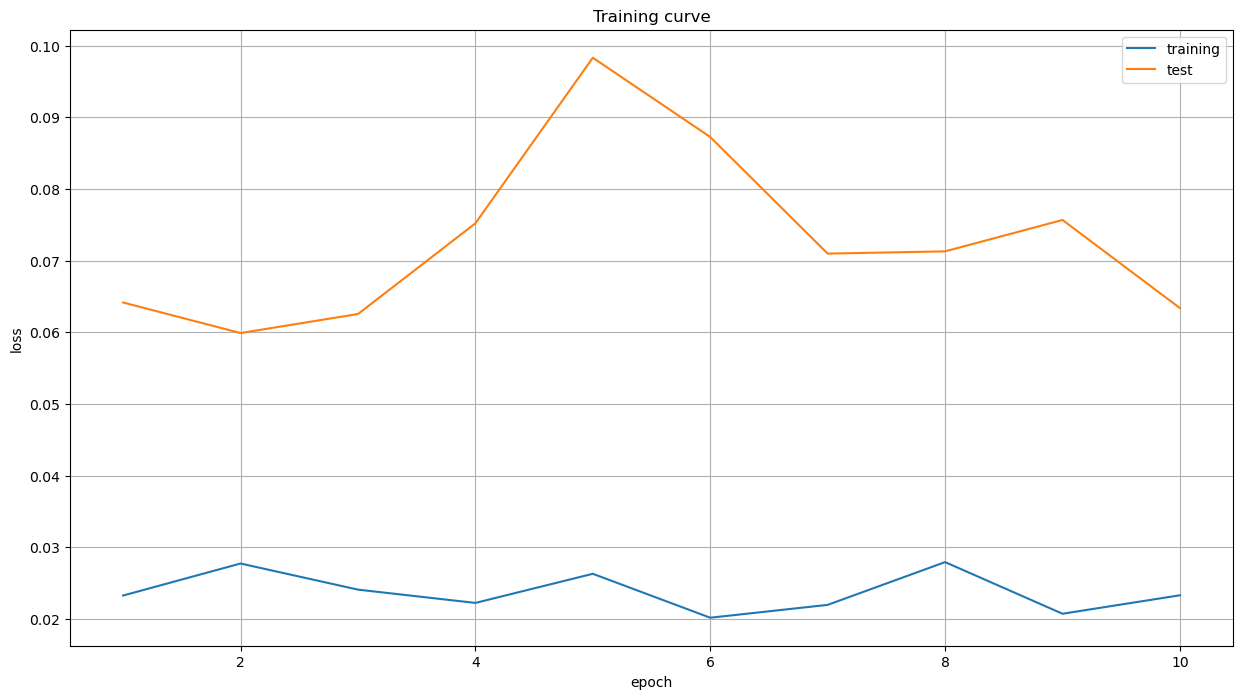

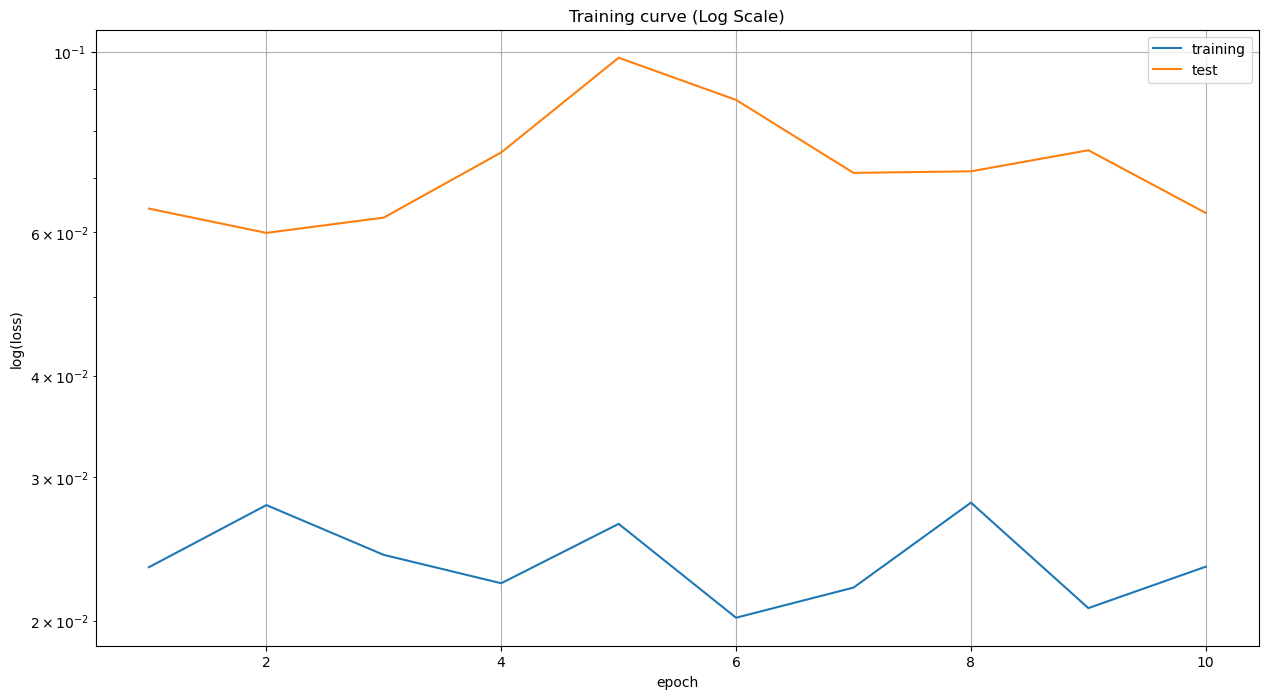

TOTAL TIME = 0.006 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmp3fy_skb4/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp3fy_skb4/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/model
-------------------------------------
epochs 11-15:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 728ms/step - loss: 0.0224 - val_loss: 0.0807
Epoch 2/5
1/1 [==============================] - 1s 564ms/step - loss: 0.0257 - val_loss: 0.0656
Epoch 3/5
1/1 [==============================] - 1s 532ms/step - loss: 0.0238 - val_loss: 0.1046
Epoch 4/5
1/1 [==============================] - 1s 506ms/step - loss: 0.0250 - val_loss: 0.0688
Epoch 5/5
1/1 [==============================] - 1s 525ms/step - loss: 0.0240 - val_loss: 0.0864


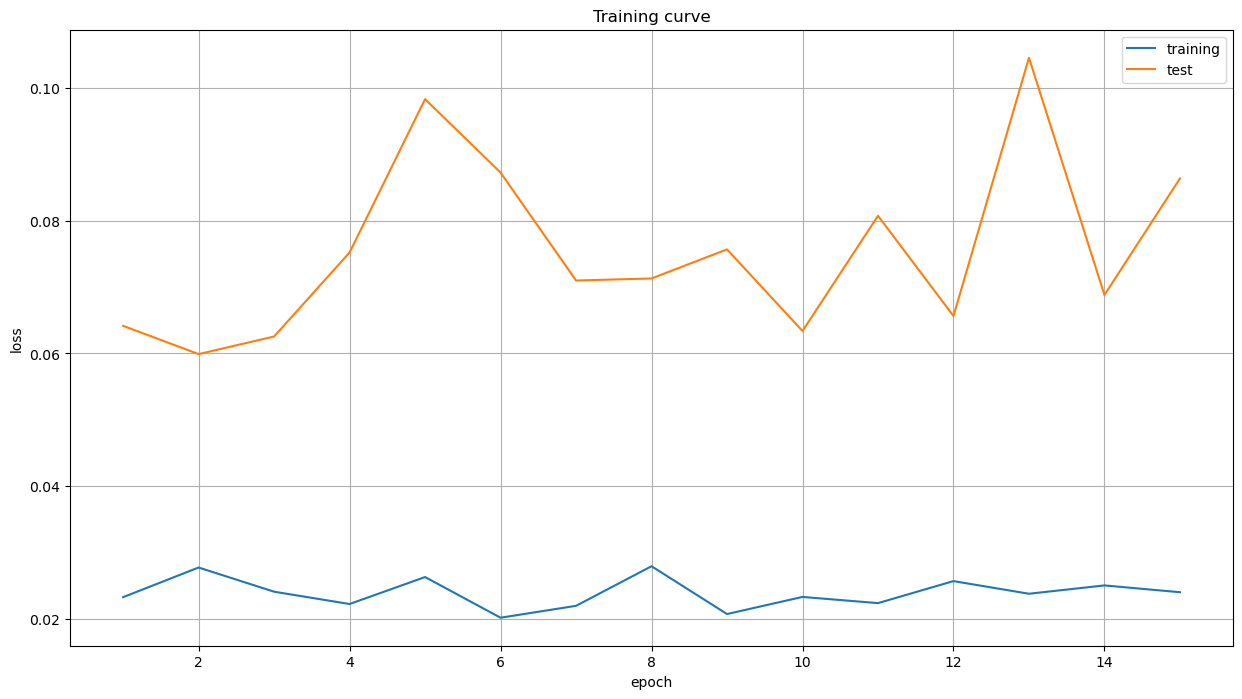

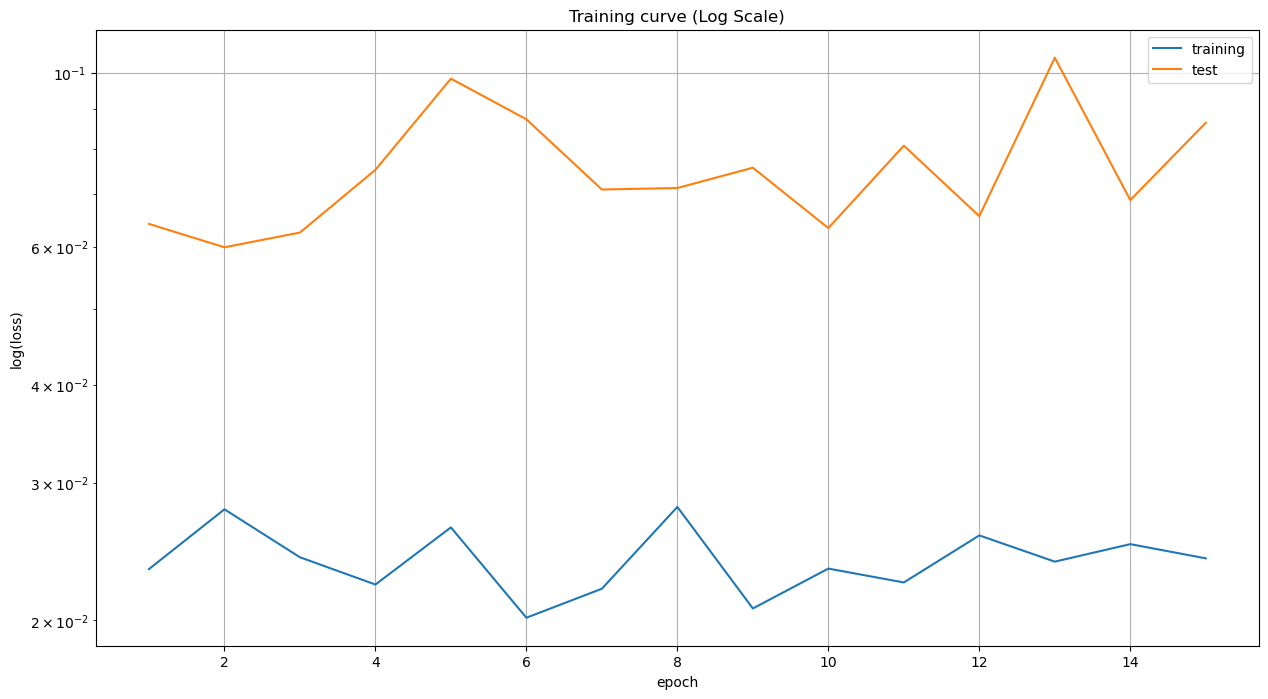

TOTAL TIME = 0.011 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpafn3gbtx/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpafn3gbtx/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/model
-------------------------------------
epochs 16-20:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 684ms/step - loss: 0.0219 - val_loss: 0.0820
Epoch 2/5
1/1 [==============================] - 1s 526ms/step - loss: 0.0254 - val_loss: 0.0825
Epoch 3/5
1/1 [==============================] - 1s 534ms/step - loss: 0.0192 - val_loss: 0.0645
Epoch 4/5
1/1 [==============================] - 1s 531ms/step - loss: 0.0227 - val_loss: 0.0792
Epoch 5/5
1/1 [==============================] - 1s 540ms/step - loss: 0.0214 - val_loss: 0.0600


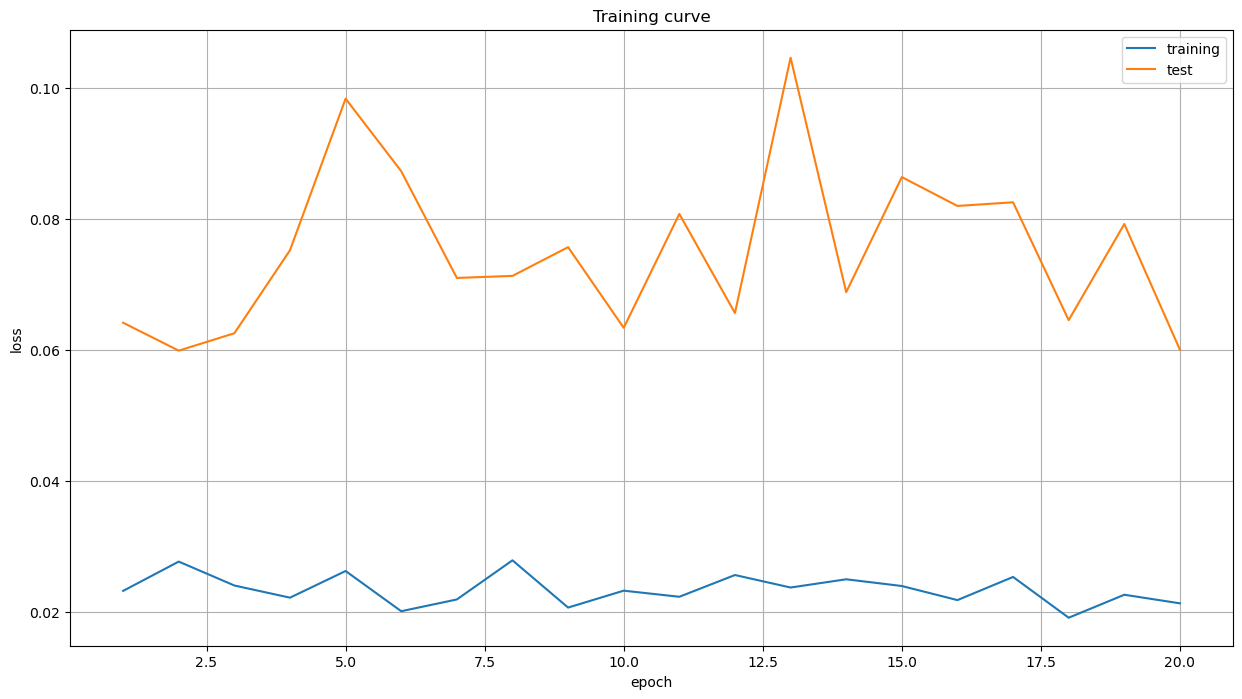

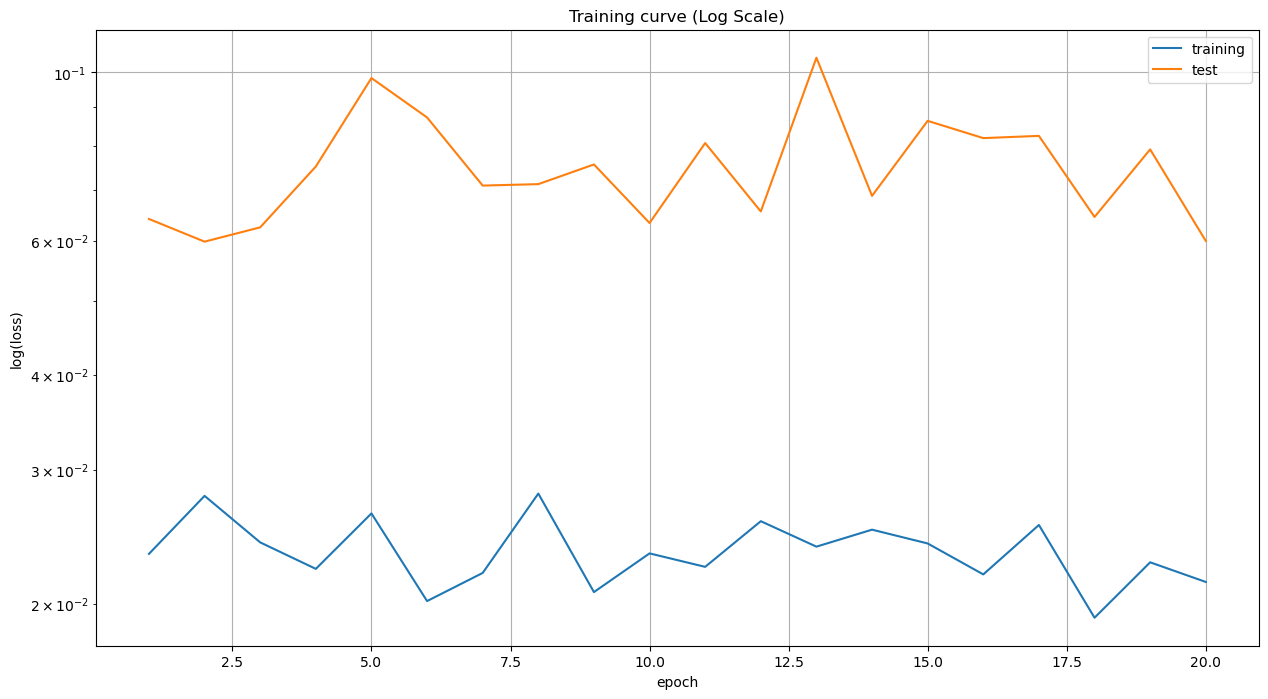

TOTAL TIME = 0.017 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmp7qgod1c9/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp7qgod1c9/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/model
-------------------------------------
epochs 21-25:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 706ms/step - loss: 0.0217 - val_loss: 0.0667
Epoch 2/5
1/1 [==============================] - 1s 528ms/step - loss: 0.0254 - val_loss: 0.0778
Epoch 3/5
1/1 [==============================] - 0s 498ms/step - loss: 0.0237 - val_loss: 0.1047
Epoch 4/5
1/1 [==============================] - 1s 561ms/step - loss: 0.0238 - val_loss: 0.1044
Epoch 5/5
1/1 [==============================] - 1s 524ms/step - loss: 0.0316 - val_loss: 0.0797


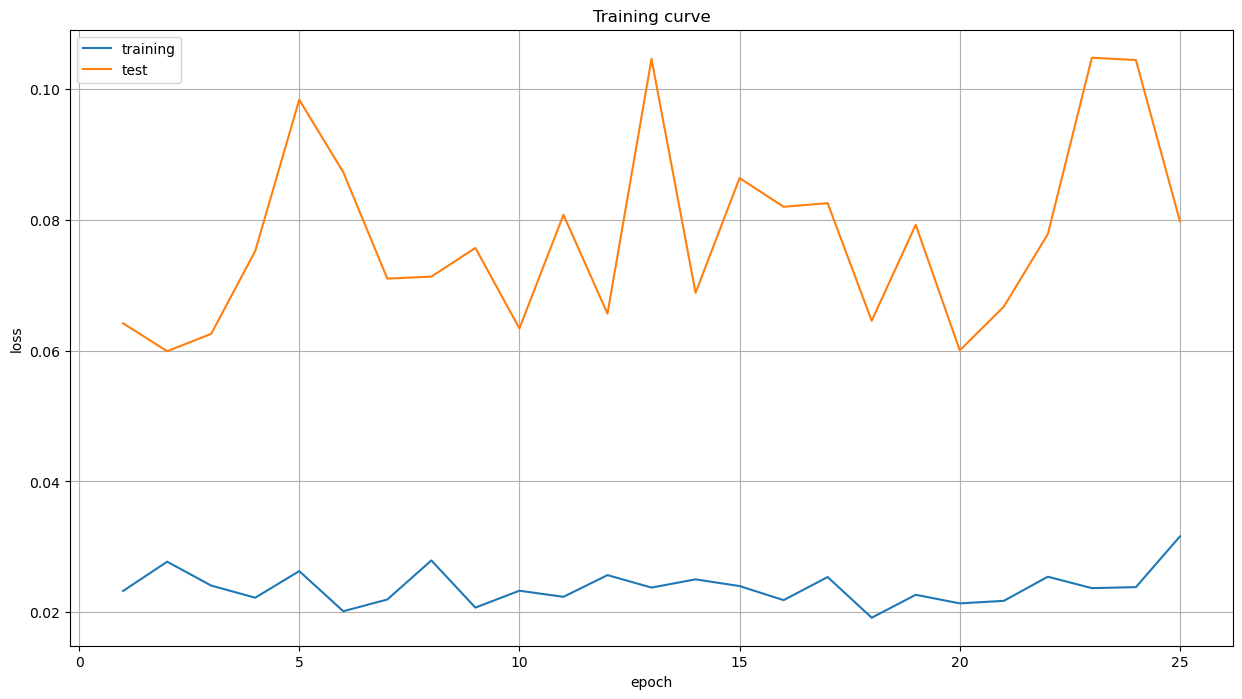

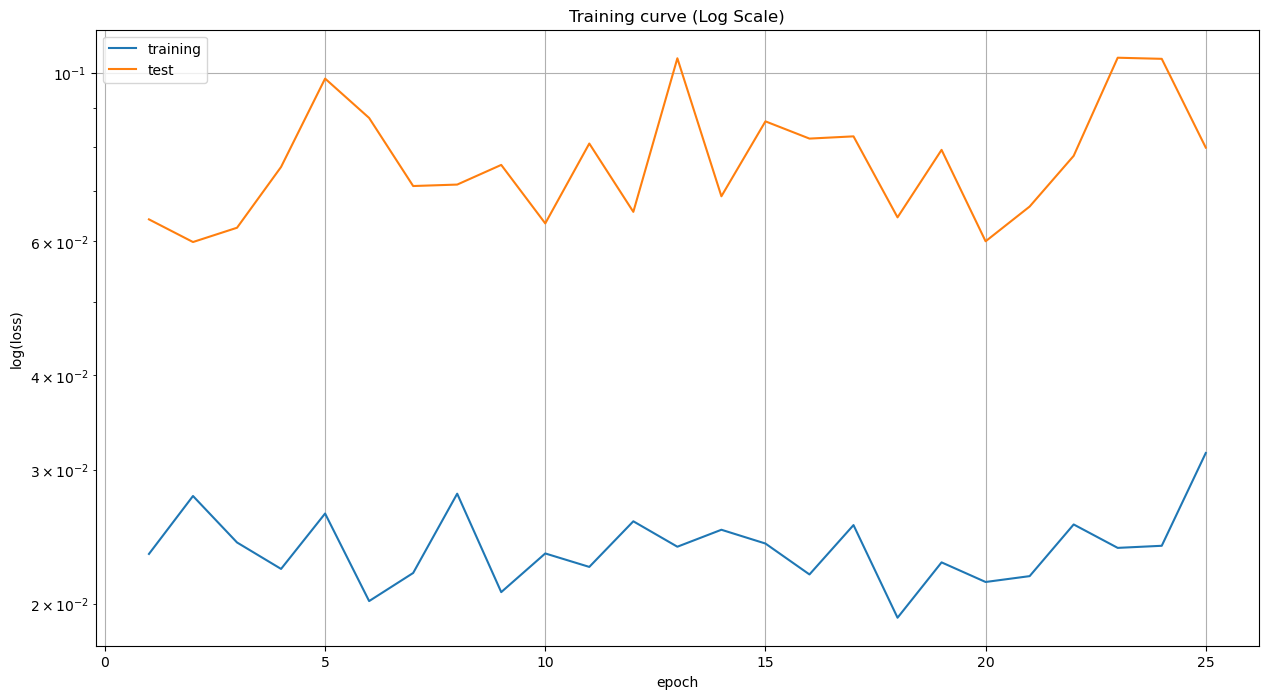

TOTAL TIME = 0.022 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpcwmp2w8m/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpcwmp2w8m/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/model
-------------------------------------
epochs 26-30:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 700ms/step - loss: 0.0204 - val_loss: 0.0916
Epoch 2/5
1/1 [==============================] - 1s 545ms/step - loss: 0.0228 - val_loss: 0.0832
Epoch 3/5
1/1 [==============================] - 1s 513ms/step - loss: 0.0222 - val_loss: 0.0729
Epoch 4/5
1/1 [==============================] - 1s 522ms/step - loss: 0.0231 - val_loss: 0.0482
Epoch 5/5
1/1 [==============================] - 1s 505ms/step - loss: 0.0297 - val_loss: 0.0760


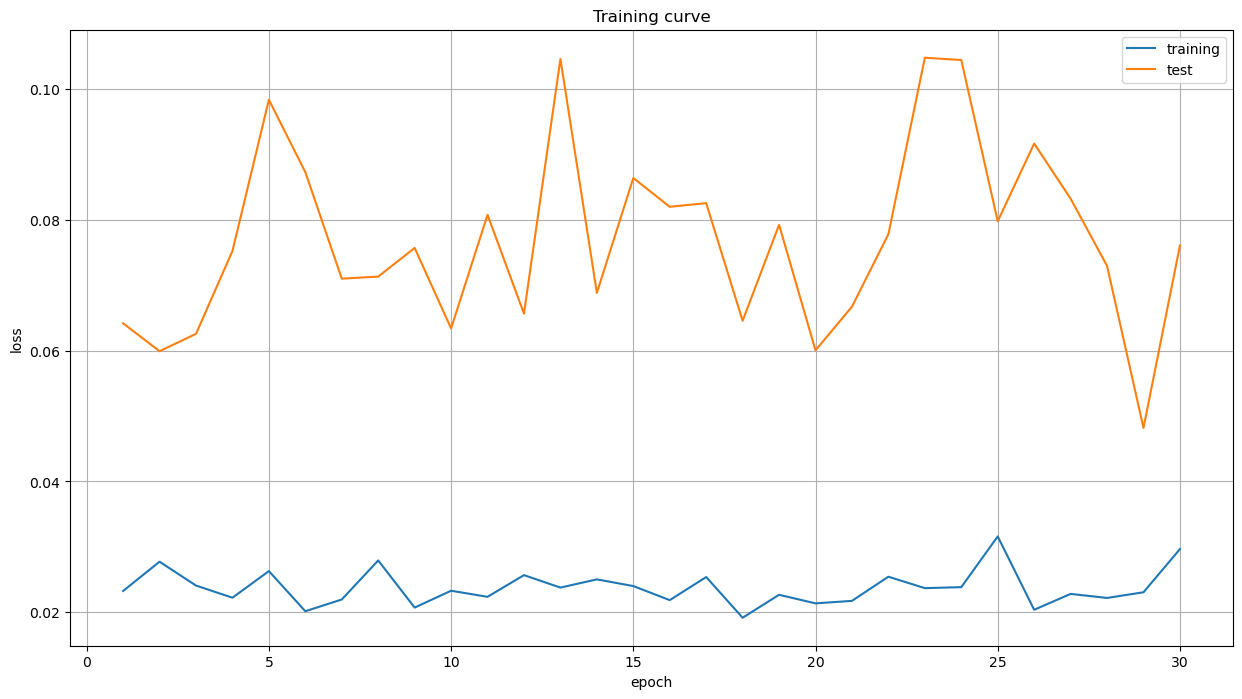

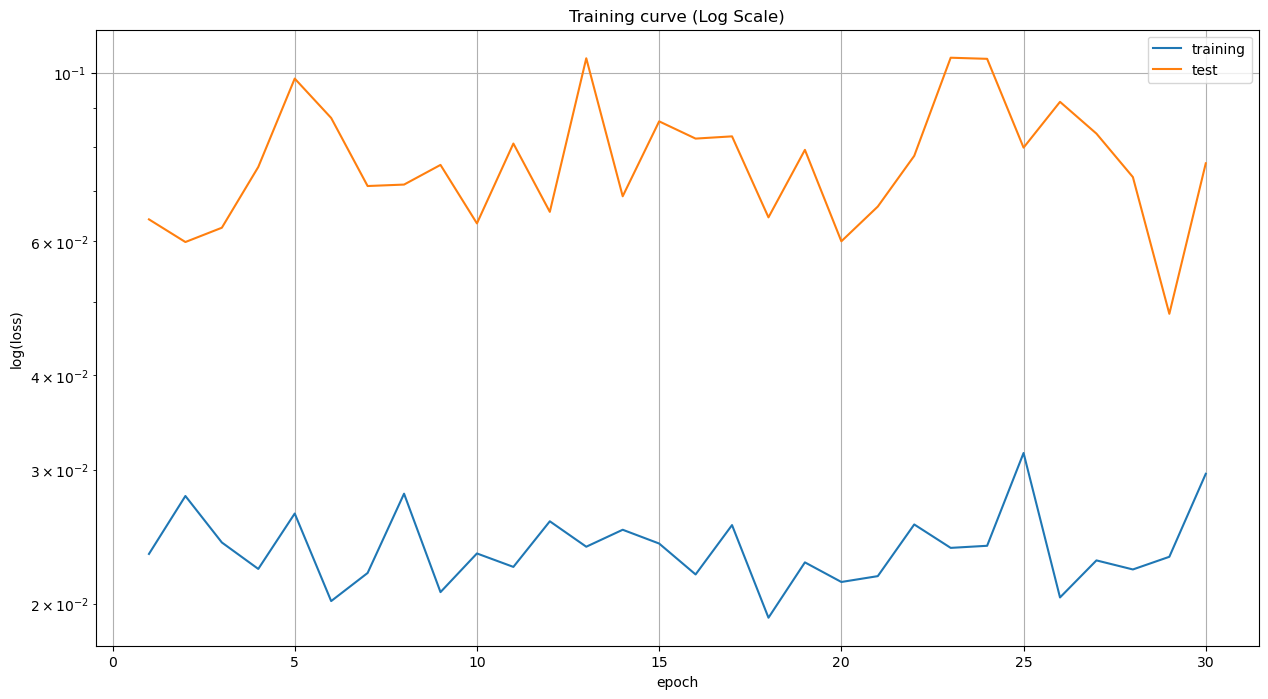

TOTAL TIME = 0.027 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmp3zknn0j_/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp3zknn0j_/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/model
-------------------------------------
epochs 31-35:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 684ms/step - loss: 0.0227 - val_loss: 0.0644
Epoch 2/5
1/1 [==============================] - 1s 562ms/step - loss: 0.0255 - val_loss: 0.0744
Epoch 3/5
1/1 [==============================] - 1s 536ms/step - loss: 0.0217 - val_loss: 0.0752
Epoch 4/5
1/1 [==============================] - 1s 570ms/step - loss: 0.0272 - val_loss: 0.0648
Epoch 5/5
1/1 [==============================] - 1s 557ms/step - loss: 0.0301 - val_loss: 0.0687


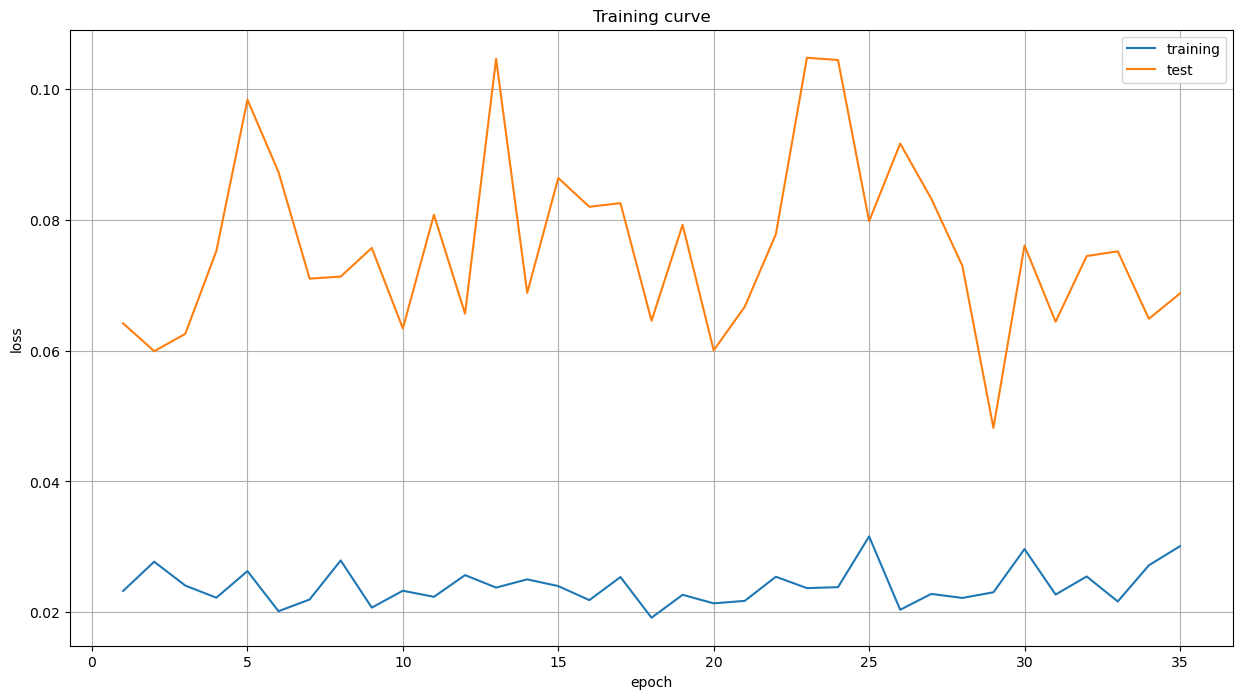

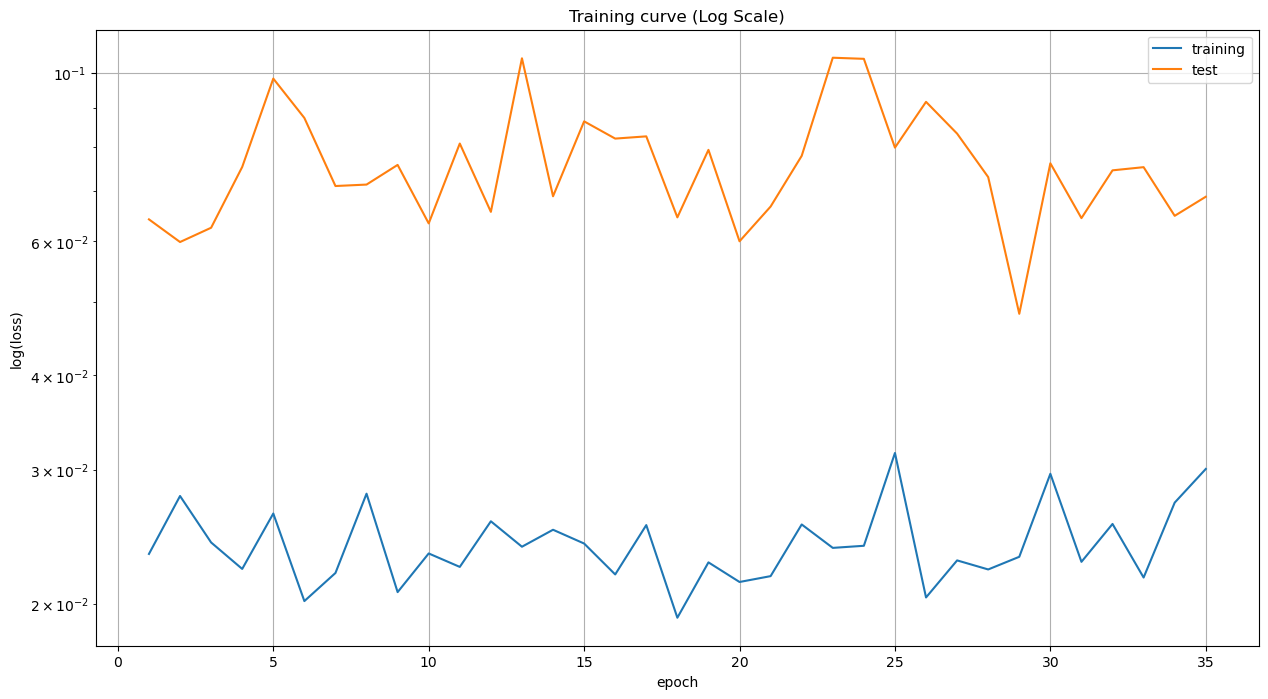

TOTAL TIME = 0.032 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpwvzdk75m/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpwvzdk75m/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/model
-------------------------------------
epochs 36-40:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 677ms/step - loss: 0.0340 - val_loss: 0.0754
Epoch 2/5
1/1 [==============================] - 1s 542ms/step - loss: 0.0351 - val_loss: 0.0910
Epoch 3/5
1/1 [==============================] - 1s 561ms/step - loss: 0.0319 - val_loss: 0.0661
Epoch 4/5
1/1 [==============================] - 1s 548ms/step - loss: 0.0218 - val_loss: 0.0467
Epoch 5/5
1/1 [==============================] - 1s 544ms/step - loss: 0.0291 - val_loss: 0.0628


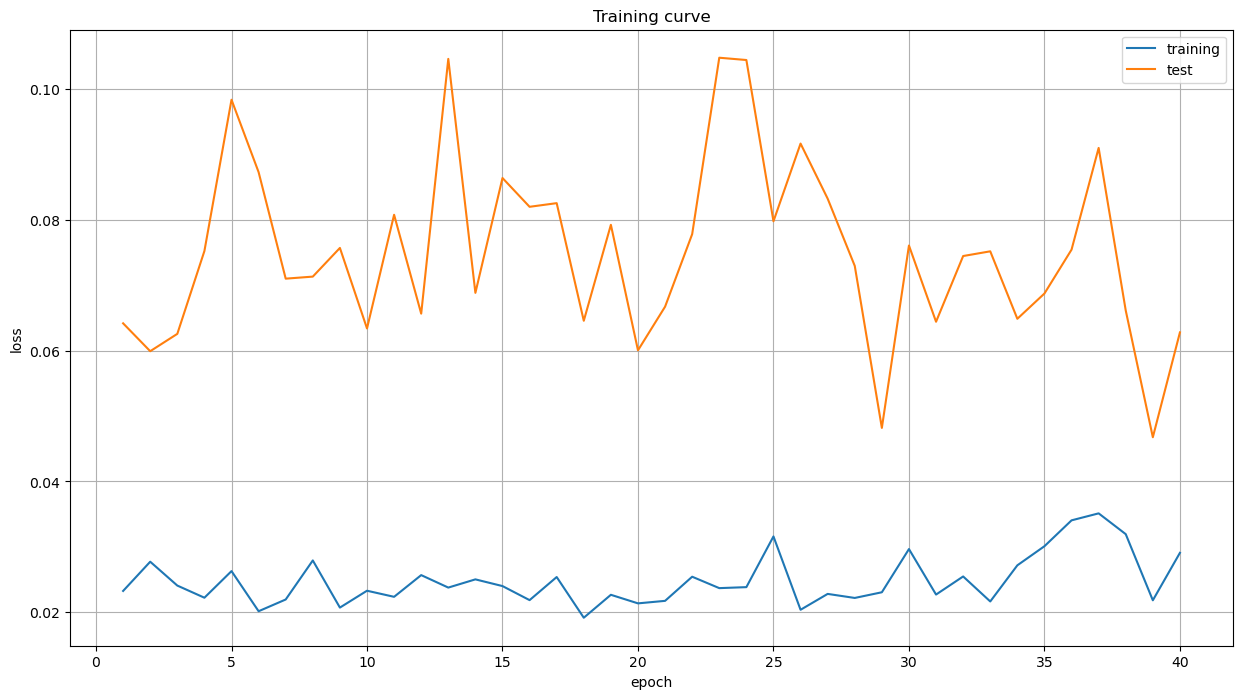

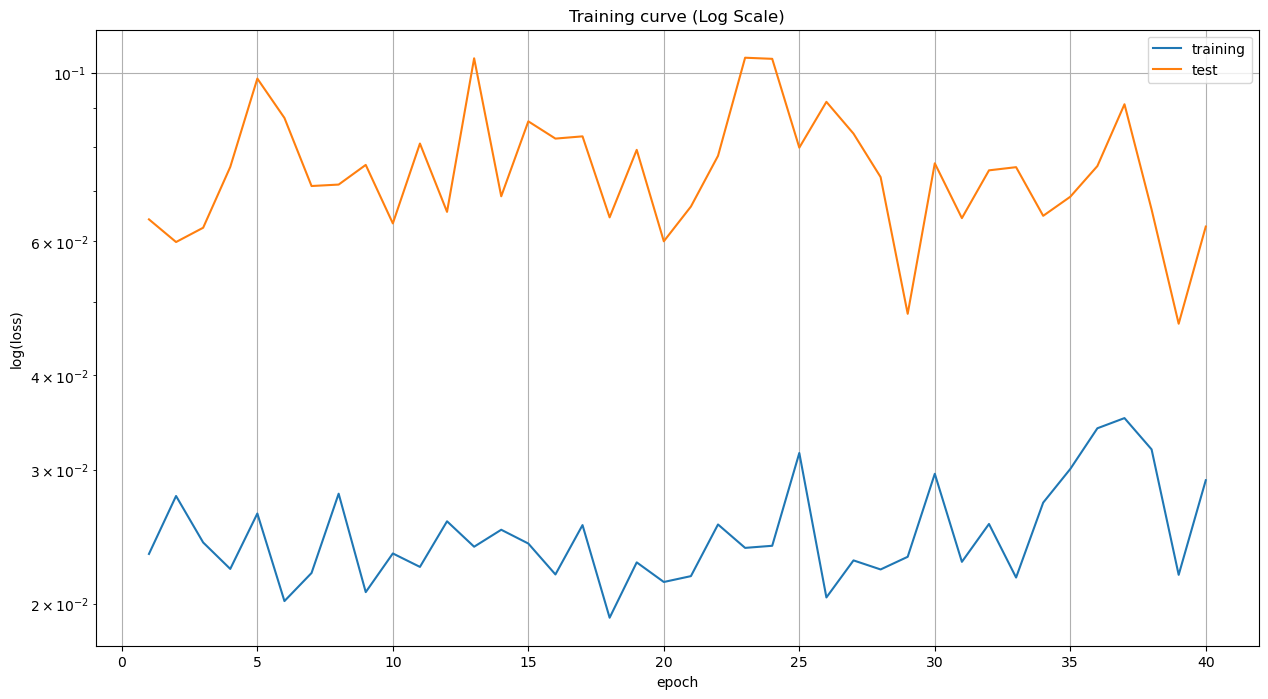

TOTAL TIME = 0.037 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpj6xr45zh/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpj6xr45zh/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/model
-------------------------------------
epochs 41-45:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 671ms/step - loss: 0.0300 - val_loss: 0.0622
Epoch 2/5
1/1 [==============================] - 1s 511ms/step - loss: 0.0234 - val_loss: 0.0816
Epoch 3/5
1/1 [==============================] - 1s 538ms/step - loss: 0.0243 - val_loss: 0.1070
Epoch 4/5
1/1 [==============================] - 1s 519ms/step - loss: 0.0245 - val_loss: 0.1141
Epoch 5/5
1/1 [==============================] - 1s 519ms/step - loss: 0.0272 - val_loss: 0.0632


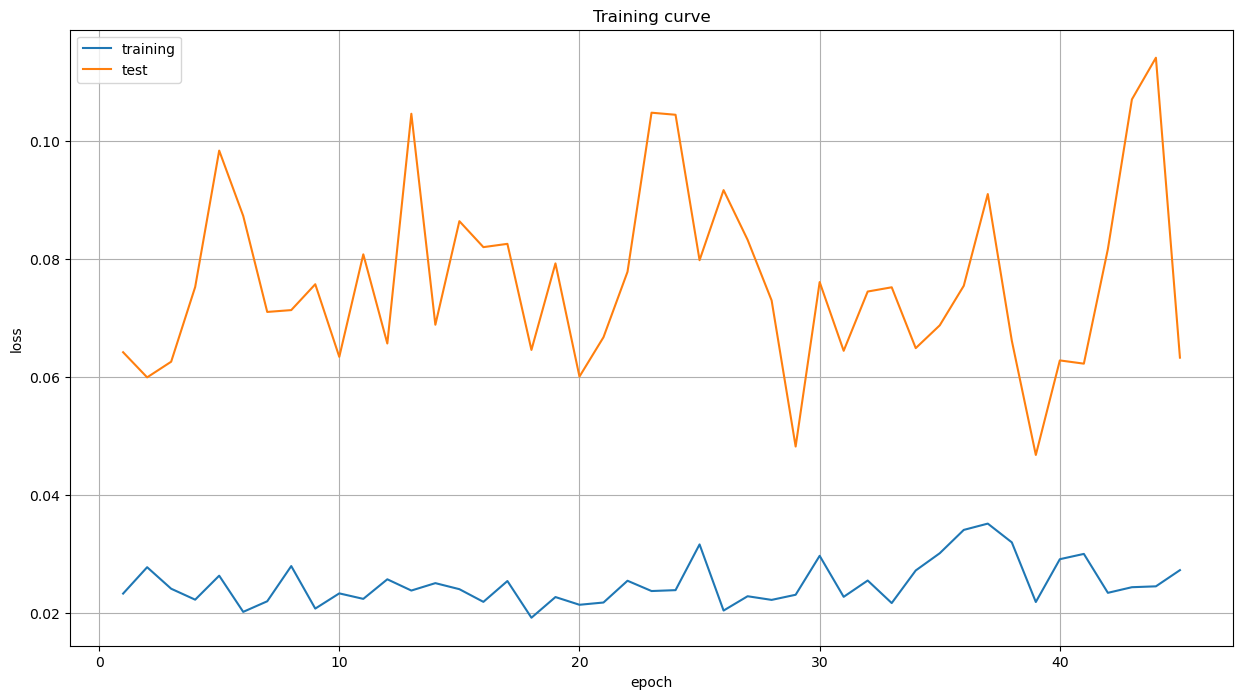

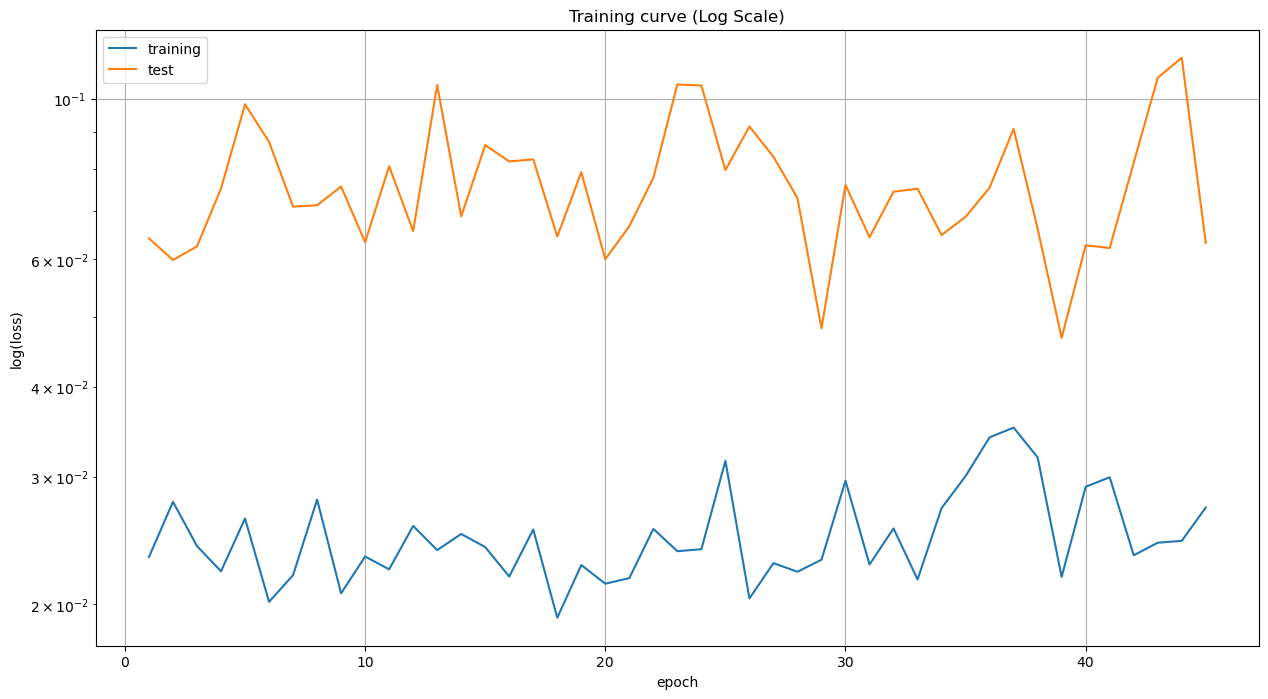

TOTAL TIME = 0.042 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpr8m4ue2n/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpr8m4ue2n/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/model
-------------------------------------
epochs 46-50:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 682ms/step - loss: 0.0252 - val_loss: 0.0893
Epoch 2/5
1/1 [==============================] - 1s 530ms/step - loss: 0.0292 - val_loss: 0.0786
Epoch 3/5
1/1 [==============================] - 1s 522ms/step - loss: 0.0238 - val_loss: 0.0811
Epoch 4/5
1/1 [==============================] - 1s 528ms/step - loss: 0.0265 - val_loss: 0.0822
Epoch 5/5
1/1 [==============================] - 1s 505ms/step - loss: 0.0271 - val_loss: 0.1024


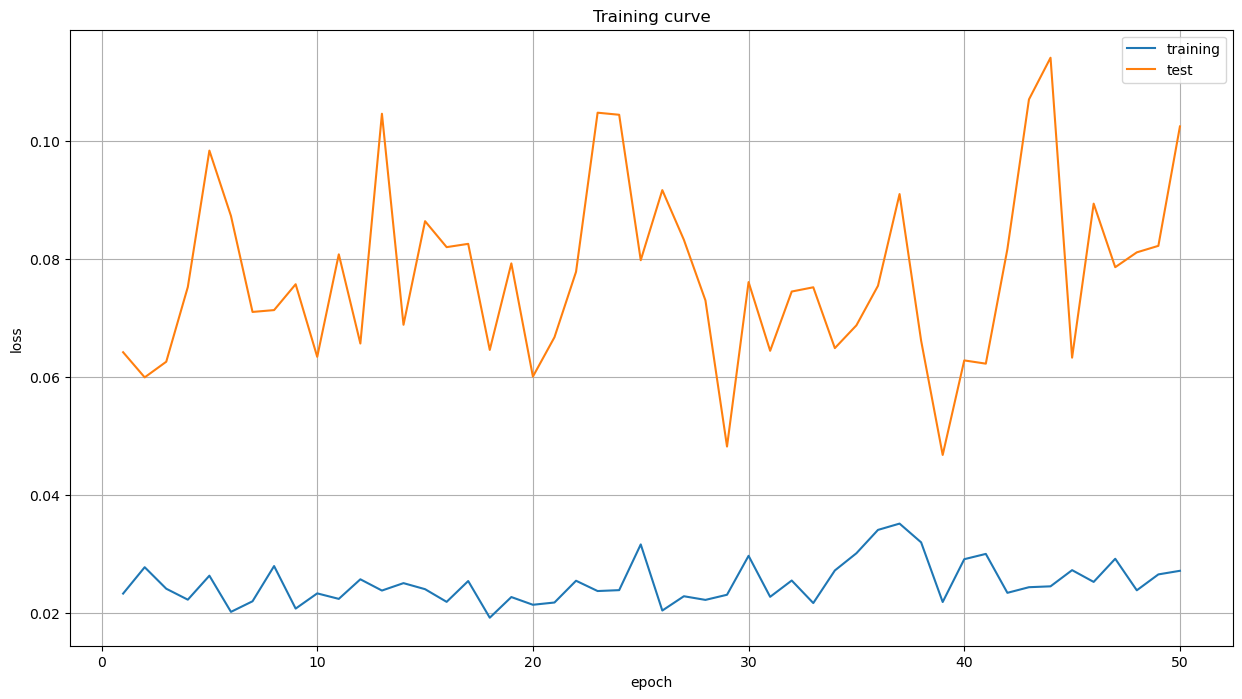

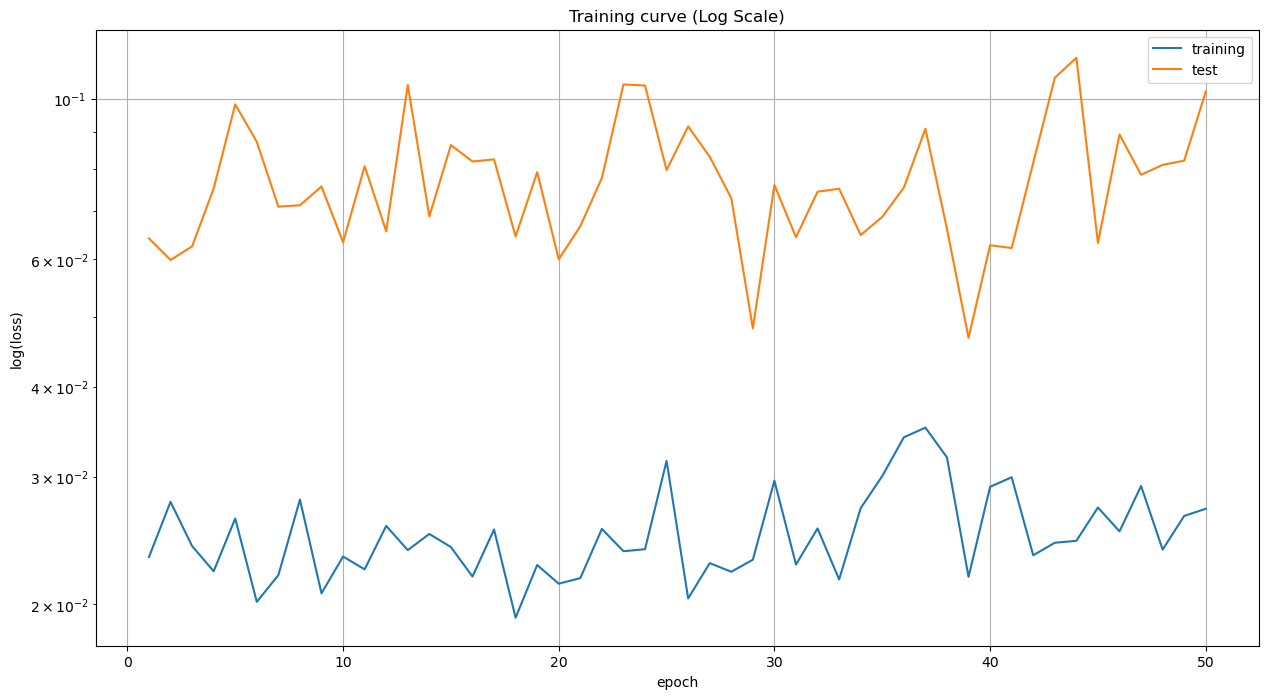

TOTAL TIME = 0.047 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmptypw93hx/model/assets


INFO:tensorflow:Assets written to: /tmp/tmptypw93hx/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/model


In [28]:
epochs = 50
sub_epochs = 5
N_chunks = int(epochs/sub_epochs)
loss_history = []
val_loss_history = []
verbosity = 1 if is_interactive() else 2

# training loop
print('Training for {0} full epochs, and stopping for saving every {1} full epochs, for a total of {2} stages.'.format(epochs,sub_epochs, N_chunks))
start_time = time.time()
for i_chunk in range(N_chunks):
    
    print('-------------------------------------')
    print('epochs {0}-{1}:'.format(i_chunk*sub_epochs+1, (i_chunk+1)*sub_epochs))
    print('-------------------------------------')

    # train
    try:
        # for some reason, the first call to fit will throw KeyError...
        history = siamese_model.fit(train_gen, epochs=sub_epochs, validation_data=test_gen, verbose=verbosity)
    except KeyError:
        history = siamese_model.fit(train_gen, epochs=sub_epochs, validation_data=test_gen, verbose=verbosity)
    loss_history += history.history['loss']
    val_loss_history += history.history['val_loss']
    
    # create the figures for the loss
    loss_fig, loss_ax = plt.subplots(figsize=(15,8))
    loss_ax.set_title('Training curve')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.grid()
    log_loss_fig, log_loss_ax = plt.subplots(figsize=(15,8))
    log_loss_ax.set_title('Training curve (Log Scale)')
    log_loss_ax.set_xlabel('epoch')
    log_loss_ax.set_ylabel('log(loss)')
    log_loss_ax.grid()
    log_loss_ax.set_yscale('log')
    
    # plot the loss
    curr_epochs = (i_chunk+1)*sub_epochs
    e = np.arange(curr_epochs)+1
    """
    loss_ax.plot(e, loss_history, label='training')
    loss_ax.plot(e, val_loss_history, label='test')
    loss_ax.legend()
    log_loss_ax.plot(e, loss_history, label='training')
    log_loss_ax.plot(e, val_loss_history, label='test')
    log_loss_ax.legend()
    """
    plot_loss(loss_fig, loss_ax, e, loss_history, val_loss_history)
    plot_loss(log_loss_fig, log_loss_ax, e, loss_history, val_loss_history)
    plt.show()
    time.sleep(1)
    
    end_time = time.time()
    time_str = 'TOTAL TIME = {0:.3f} hours'.format((end_time - start_time)/3600)
    print(time_str)
    
    # create a sub dir
    s3_save_NN_dir_path_sub_epoch = os.path.join(s3_model_train_dir_path, 'after_{0}_epochs'.format((i_chunk+1)*sub_epochs))
    # save the figures
    to_s3_fig(loss_fig, s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'loss.png'))
    to_s3_fig(log_loss_fig, s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'loss.png'))
    # save the losses
    to_s3_npy(np.array(loss_history), s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'loss.npy'))
    to_s3_npy(np.array(val_loss_history), s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'val_loss.npy'))
    # get model summary
    stringlist = []
    encoding.summary(print_fn=lambda x: stringlist.append(x))
    encoding_summary = "\n".join(stringlist)
    stringlist = []
    siamese_network.summary(print_fn=lambda x: stringlist.append(x))
    siamese_network_summary = "\n".join(stringlist)
    # save log
    log_s3(s3_client, bucket_name, s3_model_train_dir_path, 'NN_log.txt',
        dist_mat_path = dist_mat_path,
        s3_model_train_dir_path = s3_model_train_dir_path,
        training_duration = time_str,
        encoding_summary = encoding_summary,
        siamese_network_summary = siamese_network_summary
        )
    # save the network
    s3_model_path = os.path.join(s3_save_NN_dir_path_sub_epoch, 'model')
    s3_save_TF_model(siamese_model, s3_client, bucket_name, s3_model_path)

# Inference

In [30]:
# predict
batch_size = 128
data_gen = DistillationDataGenerator(X_train,  dist_mat_train, batch_size=128, shuffle=False, seed=seed, full_epoch=True, norm=True)
Z_NN = siamese_model.predict(data_gen, verbose=verbosity)

40/40 [==============================] - 3s 67ms/step


In [33]:
# create full distance matrix
N = int((-1+np.sqrt(1+8*len(Z_NN)))/2)
D_NN = np.zeros(shape=(N,N))
D_NN[np.triu_indices(N)] = Z_NN
D_NN = D_NN.T
D_NN[np.triu_indices(N)] = Z_NN

In [35]:
# save the distance matrix
to_s3_npy(D_NN, s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'dist_mat.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/dist_mat.npy


True